Section4 Project  AI_02_김홍균
#마스크 착용 유/무 인식


#캐글 데이터 연동

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kimhongkyun","key":"a5718c7239154abd62d39822ad4b4740"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
#permission warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#kaggle dataset 다운
!kaggle datasets download -d andrewmvd/face-mask-detection
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 385M/398M [00:04<00:00, 84.8MB/s]
100% 398M/398M [00:04<00:00, 84.6MB/s]
100% 329M/330M [00:01<00:00, 210MB/s]
100% 330M/330M [00:01<00:00, 210MB/s]


In [ ]:
#kaggle dataset 압축 풀기
!unzip face-mask-12k-images-dataset.zip
!unzip face-mask-detection.zip 

#라이브러리


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPool2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing \
import RandomFlip,RandomRotation,Rescaling,RandomContrast

#Test, Train, Validation set 지정

In [ ]:
#train_df 설정
train_df = image_dataset_from_directory('/content/Face Mask Dataset/Train/',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       shuffle=True,
                                       )

Found 10000 files belonging to 2 classes.


In [ ]:
#valid_df 설정
valid_df = image_dataset_from_directory('/content/Face Mask Dataset/Validation/',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       shuffle=True,
                                       )

Found 800 files belonging to 2 classes.


In [ ]:
#test_df 설정
test_df = image_dataset_from_directory('/content/Face Mask Dataset/Test/',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       shuffle=True,
                                       )

Found 992 files belonging to 2 classes.


In [ ]:
class_name = train_df.class_names

#Image

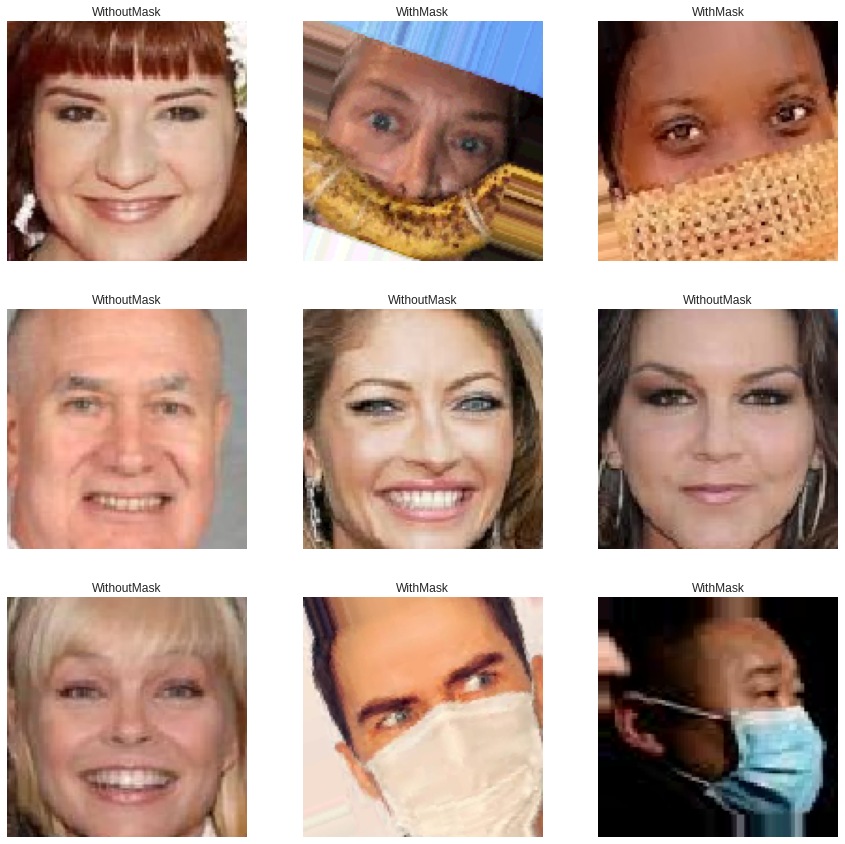

In [ ]:
#마스크 착용했는 사람들 이미지와 착용하지 않은 사람들 이미지 9장을 랜덤으로 보여주기
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

plt.figure(figsize=(15,15))
for img, label in train_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_name[int(label[i])])
        plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
valid_df = valid_df.cache().prefetch(buffer_size=AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

#Model

In [ ]:
#모델 구축
model = Sequential([
    Rescaling(1.0/255,input_shape=(128,128,3)),
    RandomFlip(),
    RandomRotation(0.4),
    RandomContrast(0.3),
    
    # First Layer
    layers.Conv2D(filters=64, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Second Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Third Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Forth Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Fivth Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6,activation='relu'),
    layers.Dense(units=1,activation='sigmoid')
    
])

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(epsilon=0.02),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [ ]:
history = model.fit(train_df,
                   validation_data=valid_df,
                   epochs=100, #50
                   batch_size=64, #32
                   )

print('\n*** Fit is over ***')

Epoch 1/100
313/313 [==============================] - 52s 60ms/step - loss: 0.5372 - binary_accuracy: 0.7097 - val_loss: 0.3362 - val_binary_accuracy: 0.8750
Epoch 2/100
313/313 [==============================] - 13s 42ms/step - loss: 0.3232 - binary_accuracy: 0.8790 - val_loss: 0.3206 - val_binary_accuracy: 0.8850
Epoch 3/100
313/313 [==============================] - 13s 43ms/step - loss: 0.2901 - binary_accuracy: 0.8900 - val_loss: 0.3150 - val_binary_accuracy: 0.8950
Epoch 4/100
313/313 [==============================] - 14s 43ms/step - loss: 0.2773 - binary_accuracy: 0.8927 - val_loss: 0.3391 - val_binary_accuracy: 0.8975
Epoch 5/100
313/313 [==============================] - 14s 44ms/step - loss: 0.2570 - binary_accuracy: 0.9010 - val_loss: 0.3453 - val_binary_accuracy: 0.8838
Epoch 6/100
313/313 [==============================] - 14s 43ms/step - loss: 0.2544 - binary_accuracy: 0.9033 - val_loss: 0.2838 - val_binary_accuracy: 0.9050
Epoch 7/100
313/313 [=========================

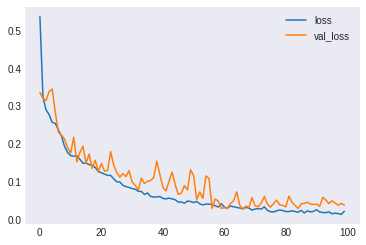

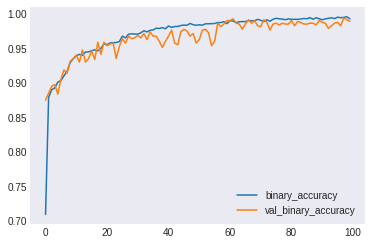

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['binary_accuracy','val_binary_accuracy']].plot()
#https://dacon.io/competitions/official/235626/codeshare/1856 

In [ ]:
test_loss, test_acc = model.evaluate(valid_df, verbose=2)

25/25 - 0s - loss: 0.0376 - binary_accuracy: 0.9887


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 128, 128, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       2

In [ ]:
def get_class(img):
    img_arr = keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img_arr, 0)
    pred = model.predict(img_arr)
    pred = (pred>0.5).astype(np.int)
    return class_name[pred[0][0]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


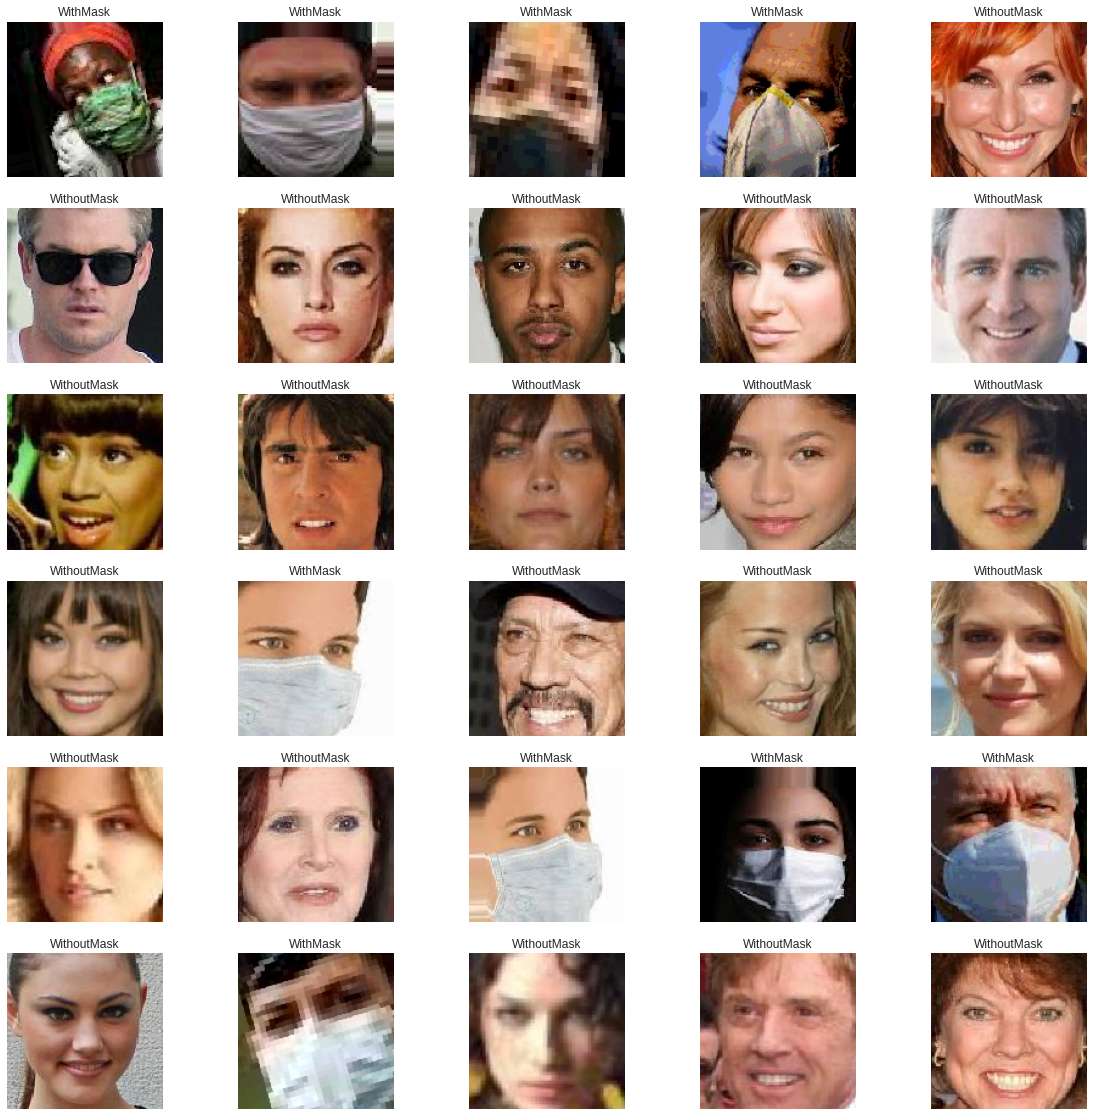

In [ ]:
plt.figure(figsize=(20,20))
for img , _ in test_df.take(5):
    for i in range(30):
        ax = plt.subplot(6,5,i+1)
        plt.imshow(img[i])
        plt.title(get_class(img[i]))
        plt.axis('off')

#또 다른 방법


In [ ]:
#https://www.kaggle.com/shahf11/face-mask-detection-with-densenet201-99-6-acc

In [ ]:
from google.colab import files
files.upload()

Saving without_20210701.jpg to without_20210701.jpg


{'without_20210701.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00XExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x02\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00&\x00\x00\x00\x00\x00\x03\xa0\x01\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\xa0\x02\x00\x04\x00\x00\x00\x01\x00\x00\x03\xc1\xa0\x03\x00\x04\x00\x00\x00\x01\x00\x00\x03\xc1\x00\x00\x00\x00\xff\xed\x008Photoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x00\x008BIM\x04%\x00\x00\x00\x00\x00\x10\xd4\x1d\x8c\xd9\x8f\x00\xb2\x04\xe9\x80\t\x98\xec\xf8B~\xff\xc0\x00\x11\x08\x03\xc1\x03\xc1\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDE

In [ ]:
import numpy as np
import os
from PIL import Image

#Visualization and evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.math import confusion_matrix

# Net libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
path = "/content/Face Mask Dataset/"
example_with_mask = path + '/Train/WithMask/1.jpg'
example_without_mask = path + '/Train/WithoutMask/0.jpg'

# Global Variables
BATCH_SIZE = 64
EPOCHS = 8
TARGET_SIZE = (128,128)
CLASSES = ['Without Mask ','With Mask']

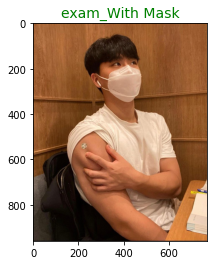

In [ ]:
plt.title('exam_With Mask', color = "green", size = 14)
plt.imshow(load_img(example_with_mask))

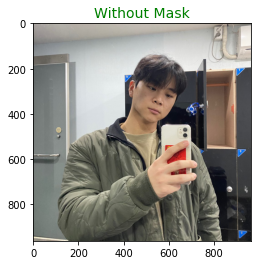

In [ ]:
plt.title('Without Mask', color = "green", size = 14)
plt.imshow(load_img(example_without_mask))

#Image Augmentation (이미지 증강)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

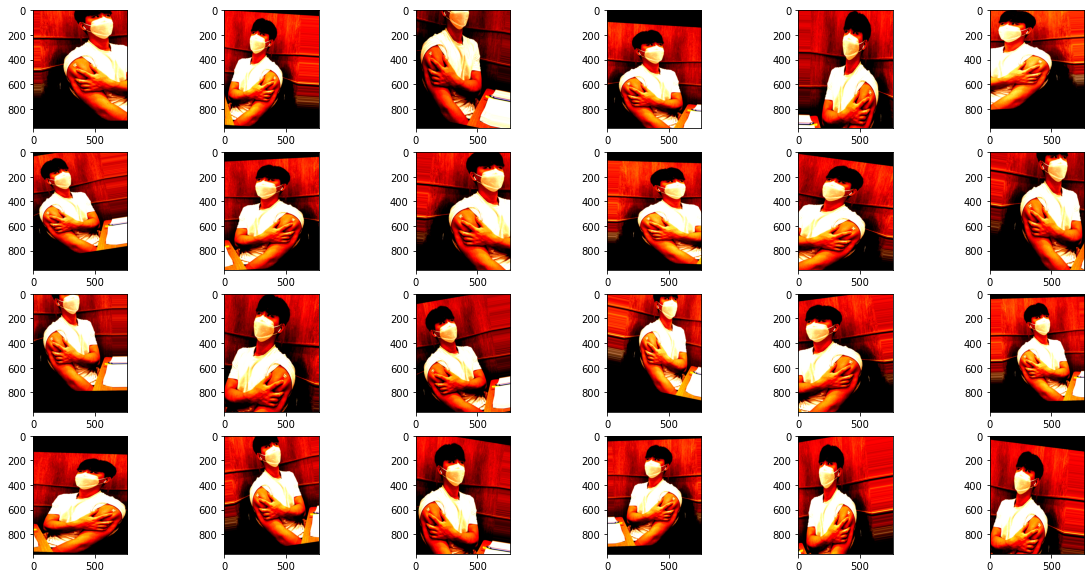

In [ ]:
#ImageDataGenerator 공식 문석 - https://keras.io/api/preprocessing/image/
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,  #이미지 회전 범위 (degrees)     
                                   width_shift_range=0.2,  #그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
                                   height_shift_range=0.2, #그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
                                   zoom_range=0.25,  #임의 확대/축소 범위
                                   horizontal_flip=True, #True로 설정할 경우, 50% 확률로 이미지를 수평으로 뒤집습니다. 원본 이미지에 수평 비대칭성이 없을 때 효과적입니다. 즉, 뒤집어도 자연스러울 때 사용하면 좋습니다.
                                   samplewise_center=True, 
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest') #이미지를 회전, 이동하거나 축소할 때 생기는 공간을 채우는 방식
test_datagen = ImageDataGenerator(rescale=1./255)

img = load_img(example_with_mask)
example_aug = img_to_array(img)/255.
#input have 4 axis - need to add extra empty axis for batch
example_aug = example_aug[np.newaxis]
plt.figure(figsize=(20,10))

for i,img in enumerate(train_datagen.flow(example_aug, batch_size=1)):
    plt.subplot(4, 6, i+1)
    #remove empty axis 
    plt.imshow(np.squeeze(img))
    
    if i == 23:
        break
    
plt.show()

In [ ]:
train_set = train_datagen.flow_from_directory(directory= path+'Train', batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE)
validation_set = test_datagen.flow_from_directory(path + 'Validation',target_size=TARGET_SIZE)

Found 10005 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
def craete_model():
    
    denseNet_model = DenseNet201(input_shape=TARGET_SIZE + (3,), weights='imagenet', include_top=False)
    denseNet_model.trainable = False
    
    flatten = Flatten()(denseNet_model.layers[-1].output)
    fc = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.35)(fc)
    output = Dense(2, activation='softmax')(dropout)
   
    model = Model(inputs=denseNet_model.input, outputs=output)
    
    model.summary()
    
    return model


model = craete_model()

74842112/74836368 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_____________________________

#Model

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(epsilon=0.02),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [ ]:
history = model.fit(train_set,
                    epochs=EPOCHS, steps_per_epoch=len(train_set), # How many mini_batchs we have inside each epoch.
                    validation_data=validation_set,
                    verbose=1)

print('\n*** Fit is over ***')

Epoch 1/8
157/157 [==============================] - 98s 369ms/step - loss: 0.0474 - binary_accuracy: 0.9871 - val_loss: 0.0106 - val_binary_accuracy: 0.9975
Epoch 2/8
157/157 [==============================] - 52s 333ms/step - loss: 0.0219 - binary_accuracy: 0.9935 - val_loss: 0.0066 - val_binary_accuracy: 0.9987
Epoch 3/8
157/157 [==============================] - 52s 330ms/step - loss: 0.0146 - binary_accuracy: 0.9957 - val_loss: 0.0070 - val_binary_accuracy: 0.9975
Epoch 4/8
157/157 [==============================] - 52s 331ms/step - loss: 0.0124 - binary_accuracy: 0.9965 - val_loss: 0.0096 - val_binary_accuracy: 0.9962
Epoch 5/8
157/157 [==============================] - 51s 327ms/step - loss: 0.0112 - binary_accuracy: 0.9964 - val_loss: 0.0081 - val_binary_accuracy: 0.9975
Epoch 6/8
157/157 [==============================] - 52s 330ms/step - loss: 0.0083 - binary_accuracy: 0.9975 - val_loss: 0.0078 - val_binary_accuracy: 0.9987
Epoch 7/8
157/157 [==============================] -

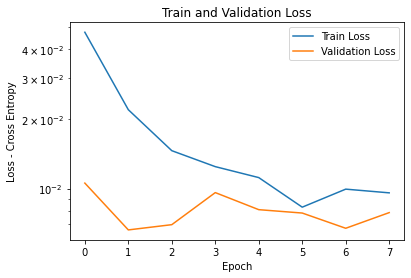

In [ ]:
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
plt.semilogy(train_loss, label='Train Loss')
plt.semilogy(val_loss, label='Validation Loss')


plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss - Cross Entropy')
plt.title('Train and Validation Loss')


plt.show()
    

In [ ]:
test_set = test_datagen.flow_from_directory(path + 'Test',target_size=TARGET_SIZE,shuffle=False)
loss, accuracy = model.evaluate(test_set)

Found 992 images belonging to 2 classes.
31/31 [==============================] - 3s 83ms/step - loss: 0.0278 - binary_accuracy: 0.9919


In [ ]:
train_set = test_datagen.flow_from_directory(path + 'Train',target_size=TARGET_SIZE,shuffle=False)
loss, accuracy = model.evaluate(train_set)

Found 10005 images belonging to 2 classes.
313/313 [==============================] - 26s 84ms/step - loss: 0.0098 - binary_accuracy: 0.9963


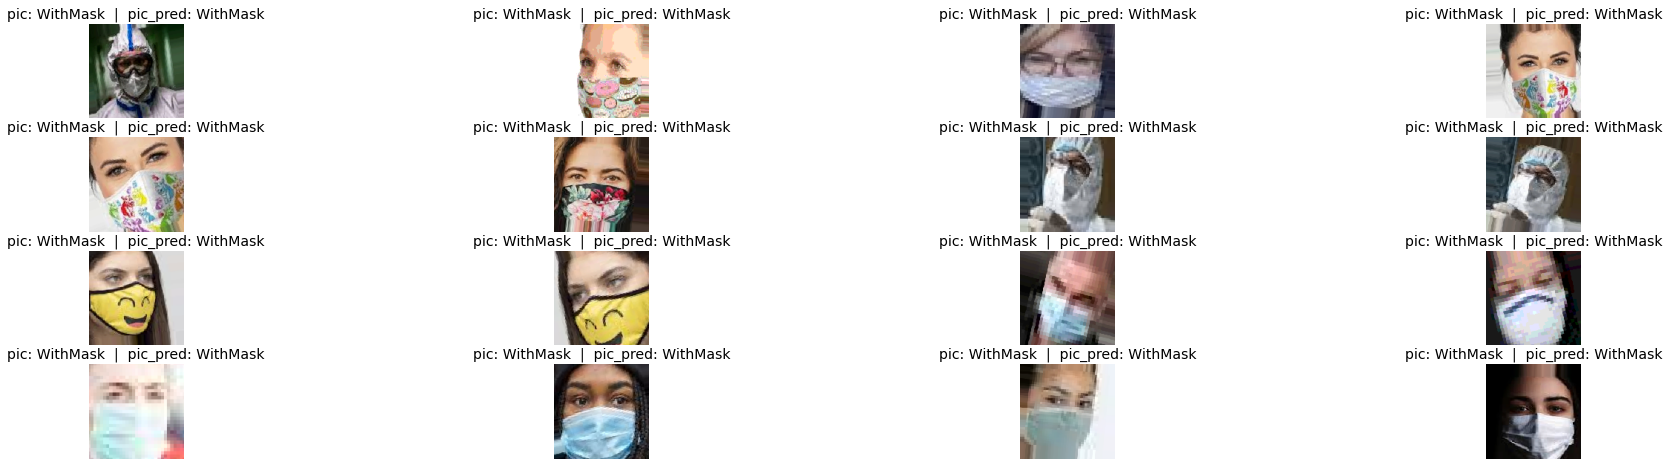

In [ ]:
# True Label & Predict of a particular Batch
image, label = test_set.next()
num_imgs = 16
lab_names = ['WithMask','WithoutMask ']
images = image[0:num_imgs,:,:,:]
labels = label[0:num_imgs,:]
predict = np.round(model.predict(images))

image_rows = 4
image_col = int(num_imgs/image_rows)

_, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
axs = axs.flatten()

for i in range(num_imgs):
    img = images[i,:,:,:]
    lab = labels[i,:]
    axs[i].imshow(img)
    pred = predict[i]
    axs[i].axis('off')
    lab, pred = np.argmax(lab), np.argmax(pred)
    axs[i].set_title(label = f'pic: {lab_names[lab]}  |  pic_pred: {lab_names[pred]}', fontsize=14)

plt.show()